![alt-text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Studying Time Series using Dynamic Time Warping

Working with time series can sometimes be challenging as we can't always use the usual tools we would use on regular data. In particular, when comparing two regular vectors, i.e. where the vector values are **independent** of one another, we can compute a distance between the two using any of the many available norms such as the L2-norm (or **Euclidian distance**). When these vectors are actually time series, this approach is not the best approach anymore and we need distances that can **account for the time dimension**. In this notebook, we will be focusing on the **Dynamic Time Warping (DTW)** which is a method for computing the similarity between between two time series. In particular, we will investigate how this metric can be used in a machine learning context for time series classification. Then, we will look into how this distance can be used to time series embedding. And finally, we will see how DTW can be used to produce meaningful averages of time series.

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import time
import numpy as np
import pandas as pd

from numba import jit

from collections import Counter

import seaborn as sns
from matplotlib import pylab as plt

sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
plt.rcParams["figure.figsize"] = (18, 8)

# DTW algorithm

## Why DTW for time series similarity ?

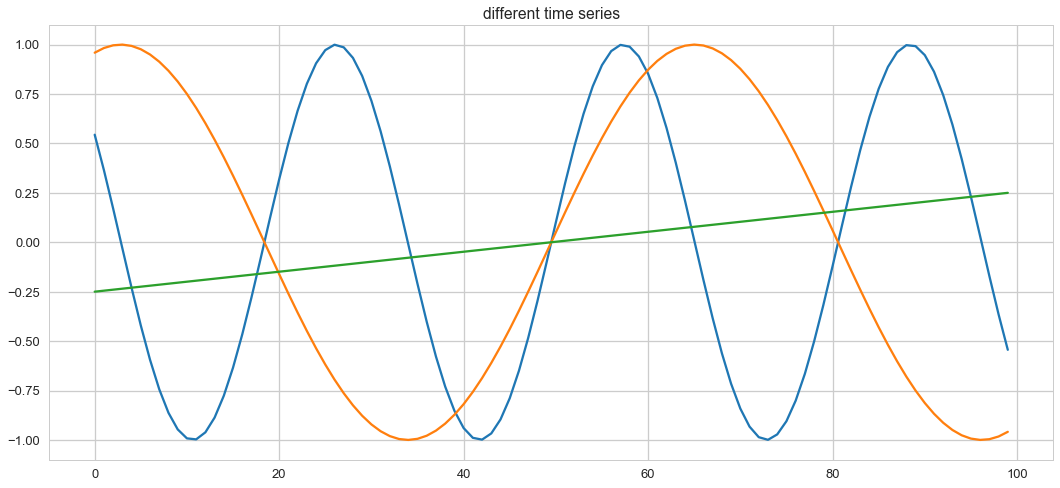

In [4]:
ts1 = np.sin(np.linspace(-10, 10, 100))
ts2 = np.sin(0.5*np.linspace(-10, 10, 100))
ts3 = 0.5*np.linspace(-10, 10, 100)/20
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)
plt.title("different time series")
plt.savefig("some_time_series.png")
plt.show()

### Euclidian distance

In [5]:
def euclidian_distance(ts1, ts2):
    return np.linalg.norm(ts1-ts2)

print("Distance between time series 1 & 2:\t {:.2f}".format(euclidian_distance(ts1, ts2)))
print("Distance between time series 1 & 3:\t {:.2f}".format(euclidian_distance(ts1, ts3)))

Distance between time series 1 & 2:	 11.08
Distance between time series 1 & 3:	 6.79


### DTW similarity

In [6]:
@jit(nopython=True)
def compute_accumulated_cost_matrix(A, B, matrix):
    """
    Computes the DTW accumulated cost matrix between
    two time series A and B of the same size.
    """
    assert len(A) == len(B)
    
    n = len(A)
    
    matrix[0, 1:] = np.inf
    matrix[1:, 0] = np.inf
    actual_matrix = matrix[1:, 1:]

    for i in range(n):
        for j in range(n):
            actual_matrix[i, j] = (A[i]- B[j])**2

    for i in range(n):
        for j in range(n):
            actual_matrix[i, j] += min(
                matrix[i, j],
                matrix[i, j+1],
                matrix[i+1, j]
            )

    return actual_matrix

def DTW_distance(ts1, ts2):
    zeros = np.zeros((len(ts1) + 1, len(ts2) + 1))
    M = compute_accumulated_cost_matrix(ts1, ts2, zeros)
    distance = M[-1, -1] / sum(M.shape)
    return distance

In [7]:
%%timeit -n 1000
distance = DTW_distance(ts1, ts2)

The slowest run took 8.16 times longer than the fastest. This could mean that an intermediate result is being cached.
95.6 µs ± 118 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
print("Distance between time series 1 & 2:\t {:.2f}".format(DTW_distance(ts1, ts2)))
print("Distance between time series 1 & 3:\t {:.2f}".format(DTW_distance(ts1, ts3)))

Distance between time series 1 & 2:	 0.17
Distance between time series 1 & 3:	 0.21


### Comparison

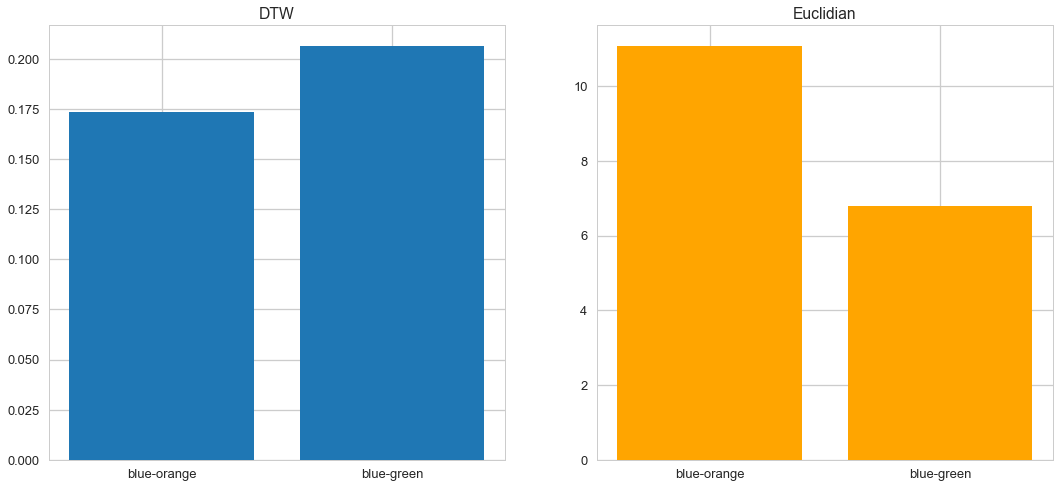

In [9]:
plt.subplot(121)
plt.title("DTW")
plt.bar(np.arange(2), [DTW_distance(ts1, ts2), DTW_distance(ts1, ts3)])
plt.xticks(np.arange(2), ["blue-orange", "blue-green"])
plt.subplot(122)
plt.title("Euclidian")
plt.bar(np.arange(2), [euclidian_distance(ts1, ts2), euclidian_distance(ts1, ts3)], color="orange")
plt.xticks(np.arange(2), ["blue-orange", "blue-green"])
plt.savefig("barplot.png")
plt.show()

The euclidian distance fails to see the similarity between the two sinusoidal curves.

## Part I : k-NN using a DTW distance

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

The time series we will be working on are those of the \textbf{Epileptic Seizure Recognition} dataset from the UCI Machine learning Repository:  
https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

These series are one second brain activity recordings of subjects that are either having an epileptic seizure or not. The recordings of subjects not having a seizure are distributed in sub-categories 2, 3, 4 or 5 whereas those of subjects having a seizure are labeled 1. Each time series has 178 points and there is a total of 11,500 time series.

In [11]:
df = pd.read_csv("data.csv")
df.index = df.pop("Unnamed: 0")

df = df.sample(frac=0.1)

y = df.pop("y").values
X = df.values

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1150, 178)
Target shape: (1150,)


In [12]:
print("Target values count:\n====================")
for v, c in sorted(Counter(y).items()):
    print(v, ":", c)

Target values count:
1 : 232
2 : 222
3 : 227
4 : 222
5 : 247


### Benchmarks

In [13]:
for split in range(3):
    
    print("=================\n")
    print(f"Random split n° {split+1}\n")
    print("=================\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    print("Number of training samples:", X_train.shape[0])
    print("Number of test samples:", X_test.shape[0])

    print()

    print("### Using the euclidian distance\n")
    
    model = KNeighborsClassifier(metric=euclidian_distance, n_neighbors=3)

    t = time.time()
    model.fit(X_train, y_train)
    print("Training time: {:.2f} seconds".format(time.time()-t))

    t = time.time()
    pred_euclidian = model.predict(X_test)
    print("Prediction time: {:.2f} seconds".format(time.time()-t))

    print()

    print(classification_report(y_true=y_test, y_pred=pred_euclidian))
    print("Accuracy: {:.2f}\n".format(accuracy_score(y_true=y_test, y_pred=pred_euclidian)))
    
    print("### Using the DTW distance\n")
    
    model = KNeighborsClassifier(metric=DTW_distance, n_neighbors=3)

    t = time.time()
    model.fit(X_train, y_train)
    print("Training time: {:.2f} seconds".format(time.time()-t))

    t = time.time()
    pred_DTW = model.predict(X_test)
    print("Prediction time: {:.2f} seconds".format(time.time()-t))

    print()

    print(classification_report(y_true=y_test, y_pred=pred_DTW))
    print("Accuracy: {:.2f}\n".format(accuracy_score(y_true=y_test, y_pred=pred_DTW)))


Random split n° 1


Number of training samples: 805
Number of test samples: 345

### Using the euclidian distance

Training time: 0.07 seconds
Prediction time: 2.62 seconds

             precision    recall  f1-score   support

          1       0.97      0.47      0.63        68
          2       0.25      0.64      0.36        58
          3       0.22      0.43      0.29        63
          4       0.75      0.19      0.31        62
          5       0.32      0.09      0.13        94

avg / total       0.50      0.34      0.33       345

Accuracy: 0.34

### Using the DTW distance

Training time: 0.64 seconds
Prediction time: 47.19 seconds

             precision    recall  f1-score   support

          1       0.93      0.93      0.93        68
          2       0.32      0.50      0.39        58
          3       0.47      0.41      0.44        63
          4       0.78      0.69      0.74        62
          5       0.71      0.59      0.64        94

avg / total       0.66     

### Summary

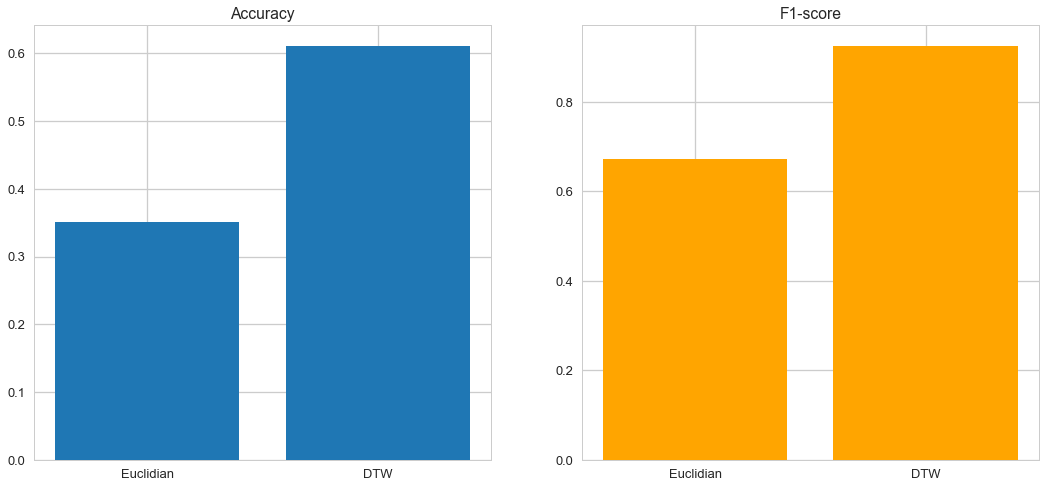

In [16]:
plt.subplot(121)
plt.title("Accuracy")
plt.bar(np.arange(2),
        [accuracy_score(y_test, pred_euclidian),
         accuracy_score(y_test, pred_DTW)])
plt.xticks(np.arange(2), ["Euclidian", "DTW"])
plt.subplot(122)
plt.title("F1-score")
plt.bar(np.arange(2),
        [f1_score(y_test==1, pred_euclidian==1),
         f1_score(y_test==1, pred_DTW==1)], color="orange")
plt.xticks(np.arange(2), ["Euclidian", "DTW"])
plt.savefig("kNN_perfs.png")
plt.show()

The DTW-based 3-NN is more successful at classifying the time series with more than 90% F1-score on predicting seizures.

## Part II : Embedding time series using a DTW distance matrix

We only use a stratified sample of 300 time series.

In [17]:
df = pd.read_csv("data.csv")
df.index = df.pop("Unnamed: 0")

df = df.sample(n=300)

y = df.pop("y").values
X = df.values

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (300, 178)
Target shape: (300,)


In [18]:
print("Target values count:\n====================")
for v, c in sorted(Counter(y).items()):
    print(v, ":", c)

Target values count:
1 : 56
2 : 59
3 : 57
4 : 65
5 : 63


We will be embedding a DTW distance matrix, which is a square matrix where the $[i,j]$ value represents the DTW distance between time series $i$ and $j$.

In [19]:
distance_matrix = np.zeros((300, 300))

t = time.time()

for i in range(300):
    for j in range(300):
        distance_matrix[i, j] = DTW_distance(X[i, :], X[j, :])

print("Elapsed time: {:.2f} seconds".format(time.time()-t))

Elapsed time: 16.18 seconds


We will try 3 different embedding methods: MMDS, t-SNE and Isomap.

In [26]:
from sklearn.manifold import MDS, TSNE, Isomap

n_components = 2
current_palette = sns.color_palette()

embedding_algorithms = [
    ("MMDS", MDS(n_components)),
    ("t-SNE", TSNE(n_components)),
    ("Isomap", Isomap(n_neighbors=3, n_components=2))
]

### Results

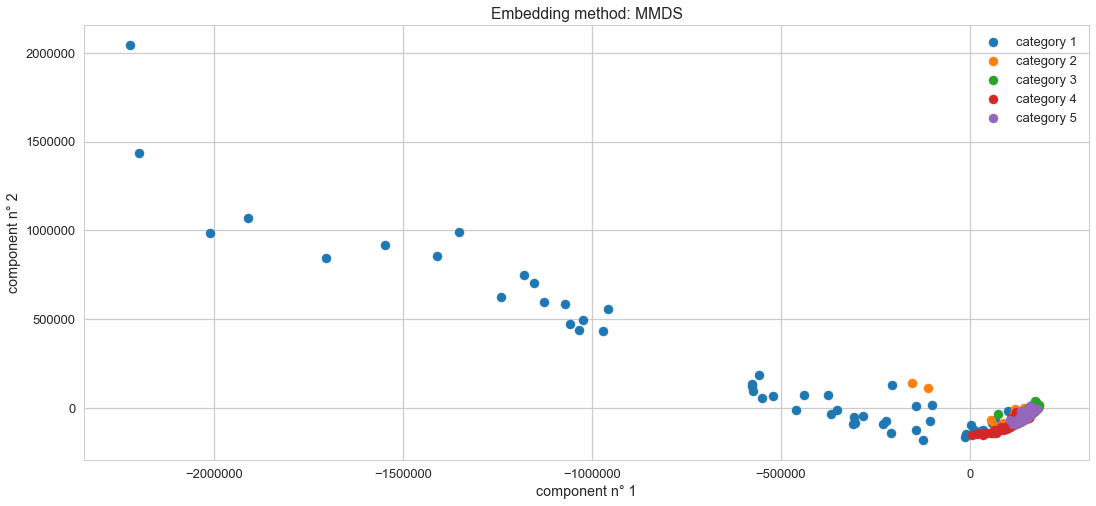

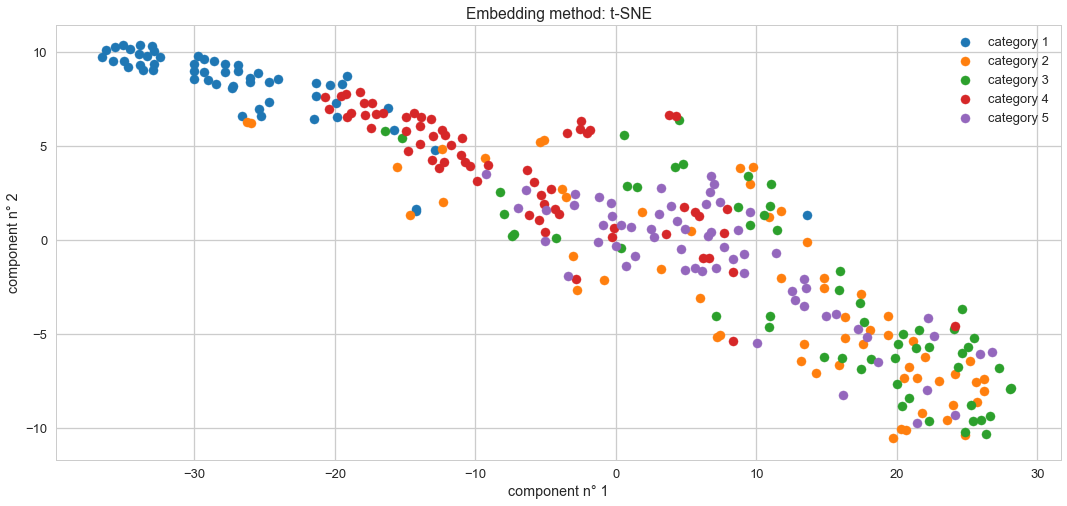

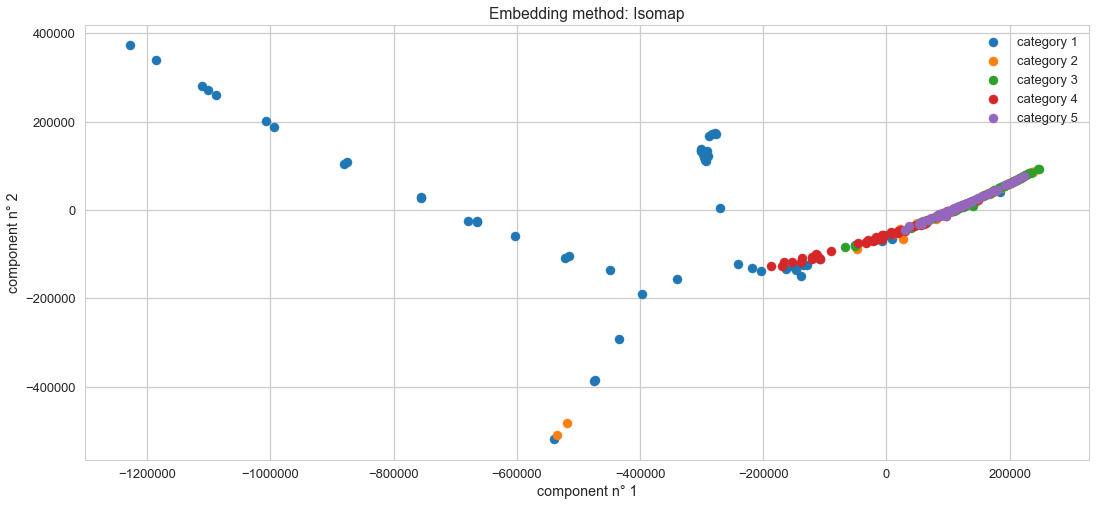

In [27]:
for name, model in embedding_algorithms:

    embedding = model.fit_transform(distance_matrix)

    plt.figure()
    plt.title(f"Embedding method: {name}")
    for v in sorted(set(y)):
        plt.scatter(embedding[y==v, 0], embedding[y==v, 1],
                    c=current_palette[v-1], label=f"category {v}")
    plt.xlabel("component n° 1")
    plt.ylabel("component n° 2")
    plt.legend()
    plt.savefig(f"{name}.png")
    plt.show()

There is a clear separation between time series of subjects having a seizure (category 1) and other time series

## Part III : Visualizing the average series per category

We will be trying to visualize the average time series per category. For that, we introduce DTW-based averaging methods: DTW Barycenter Averaging (DBA) and a variant Soft-DBA.

### DTW Barycenter Averaging (DBA)

We will be using the `tslearn` package that already has implementations for DBA and Soft-DBA.

#### Example

In [31]:
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging

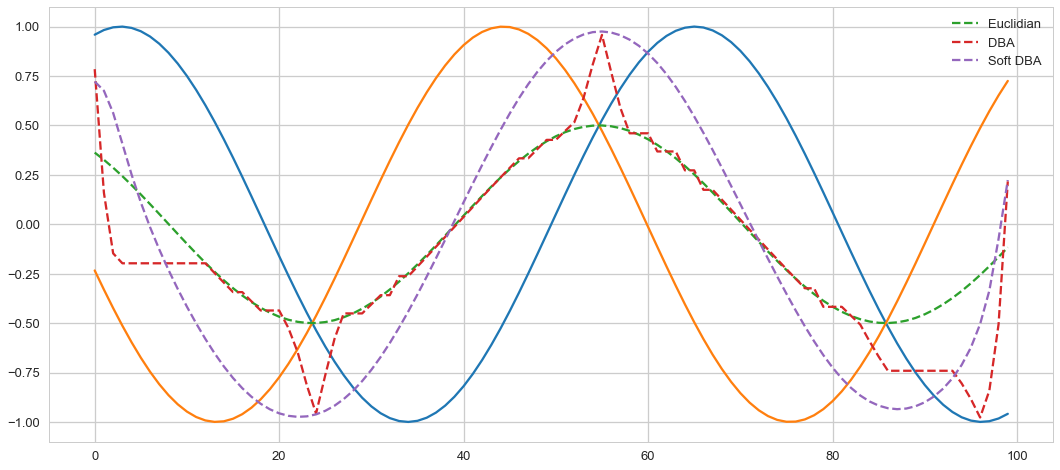

In [35]:
ts1 = np.sin(np.linspace(-5, 5, 100))
ts2 = np.sin(2*np.pi/3 + np.linspace(-5, 5, 100))
data = np.append(ts1.reshape(1, -1), ts2.reshape(1, -1), axis=0)

plt.plot(ts1)
plt.plot(ts2)

center = dtw_barycenter_averaging(data, max_iter=0)
plt.plot(center.ravel(), label=f"Euclidian", ls="--")

center = dtw_barycenter_averaging(data, max_iter=100)
plt.plot(center.ravel(), label=f"DBA", ls="--")

center = softdtw_barycenter(data, max_iter=100)
plt.plot(center.ravel(), label=f"Soft DBA", ls="--")

plt.legend()
plt.savefig("SoftDBA_example.png")
plt.show()

#### Per category comparison

Category: 1


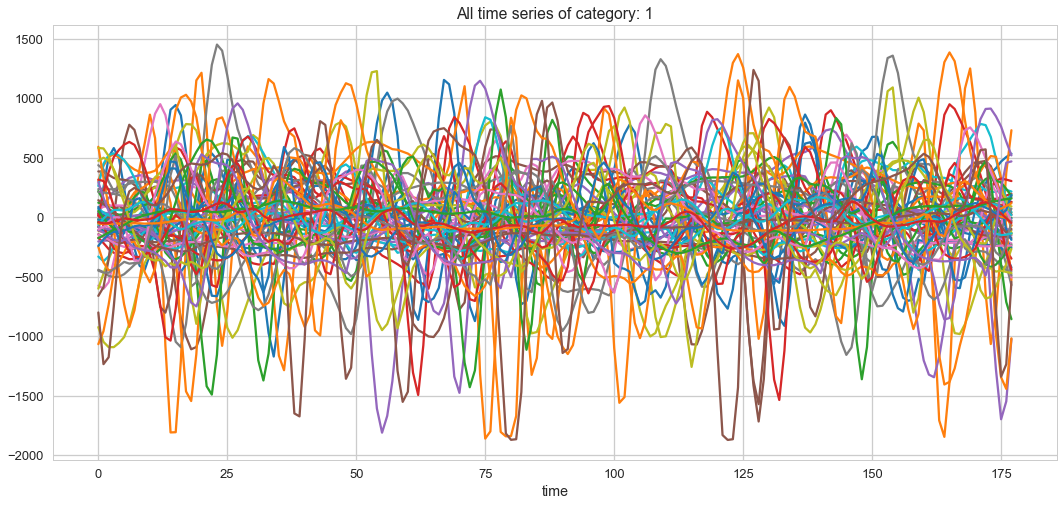

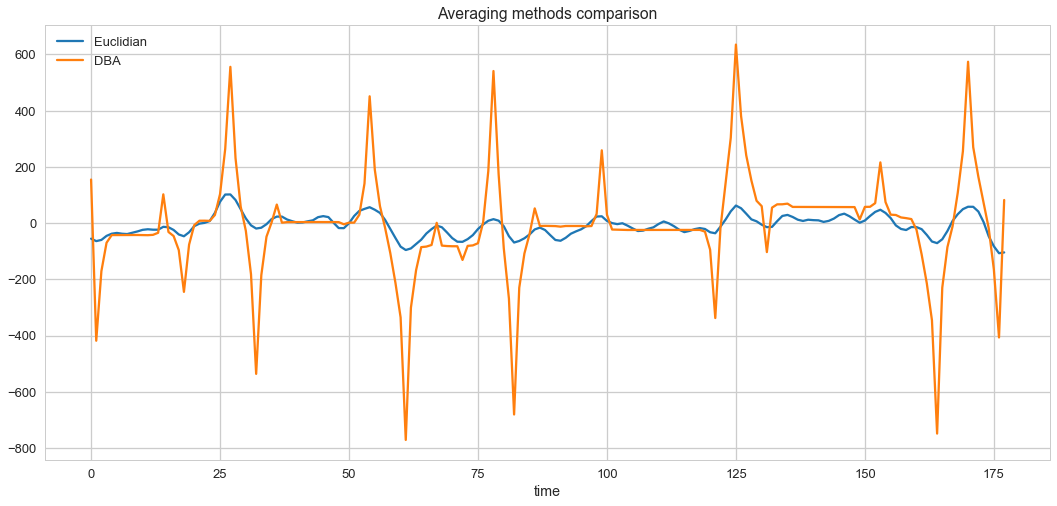

Category: 2


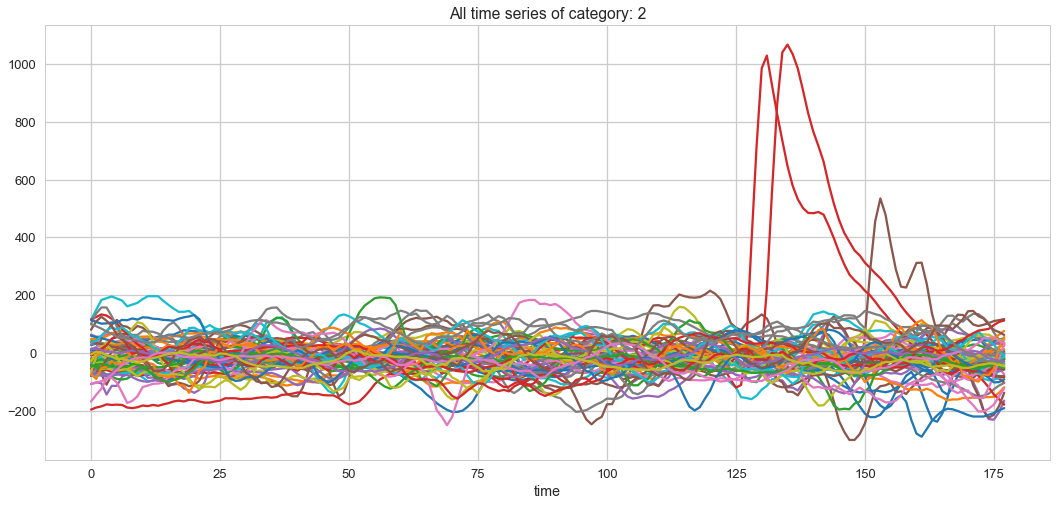

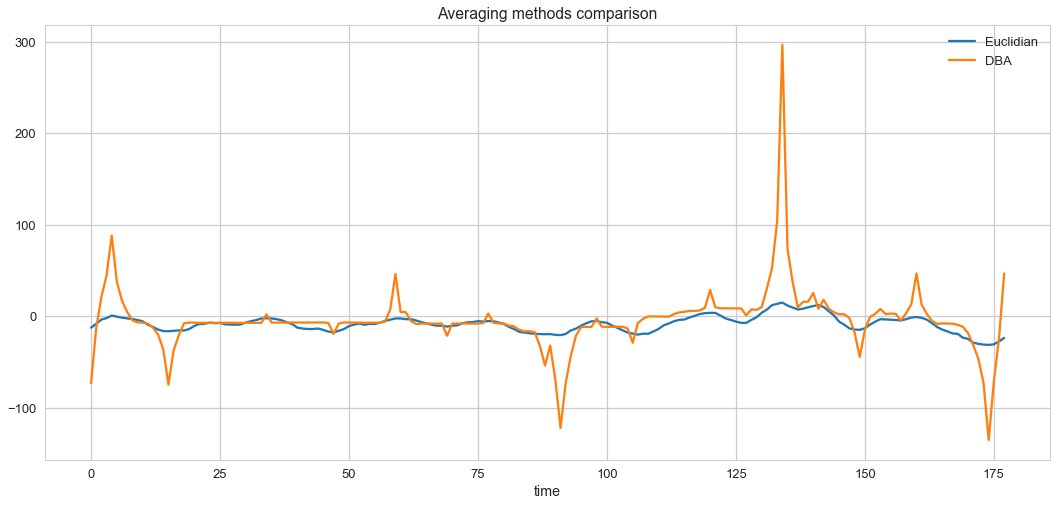

Category: 3


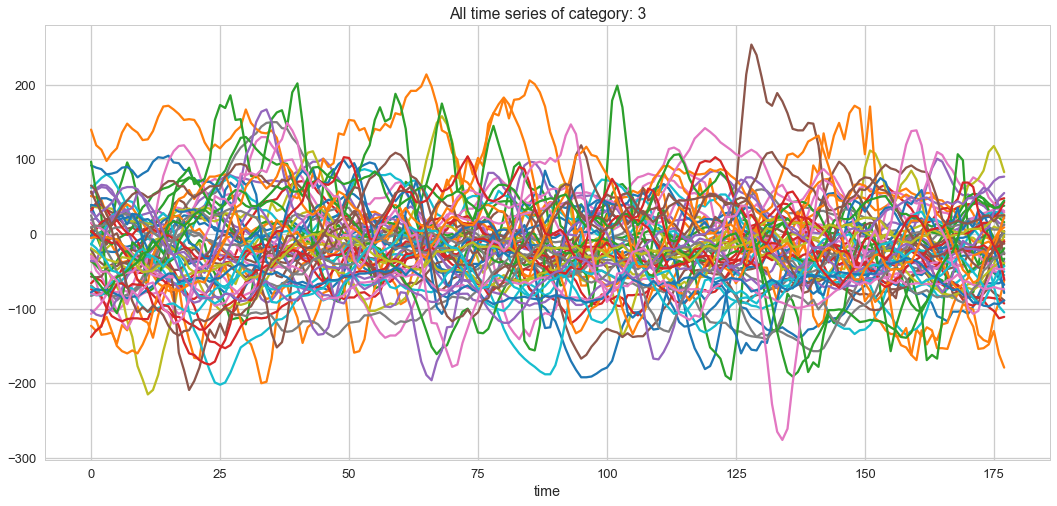

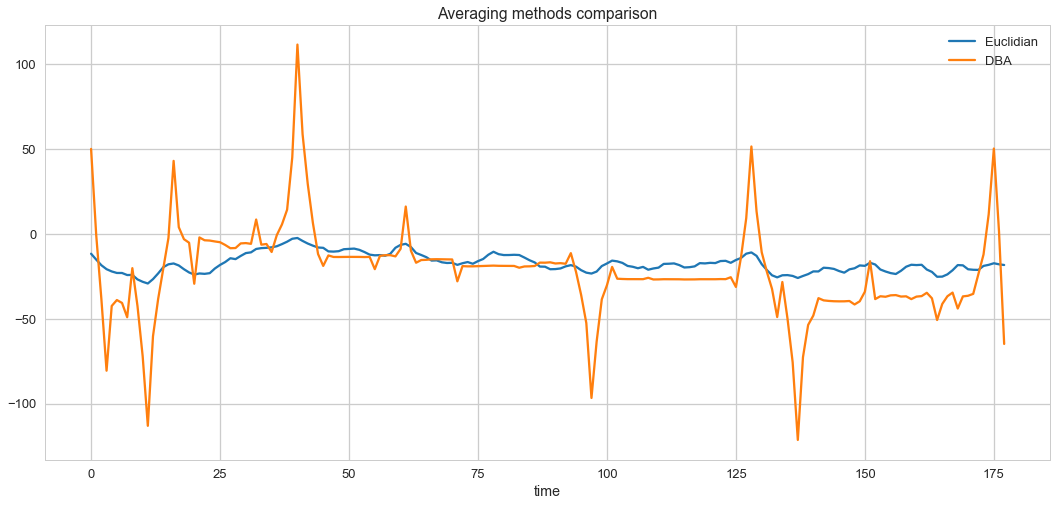

Category: 4


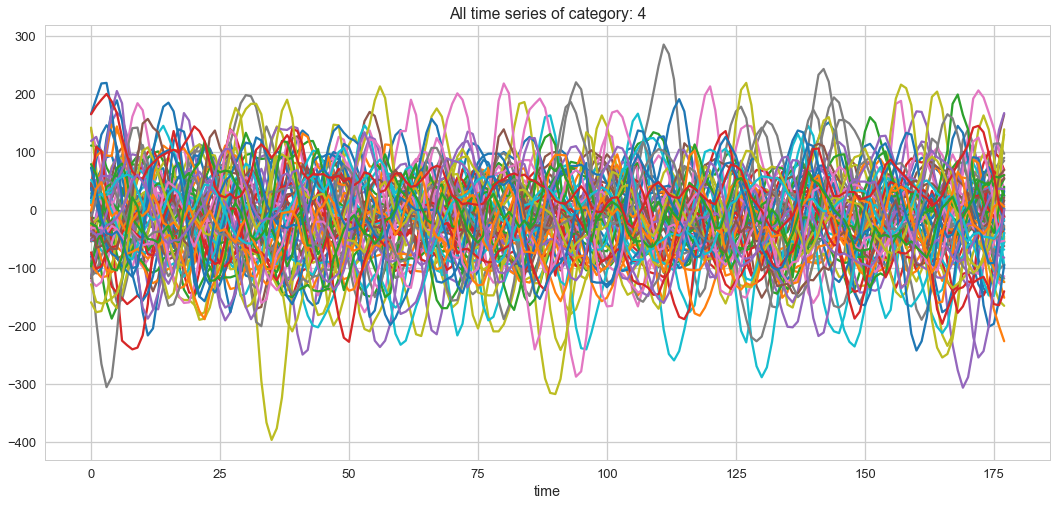

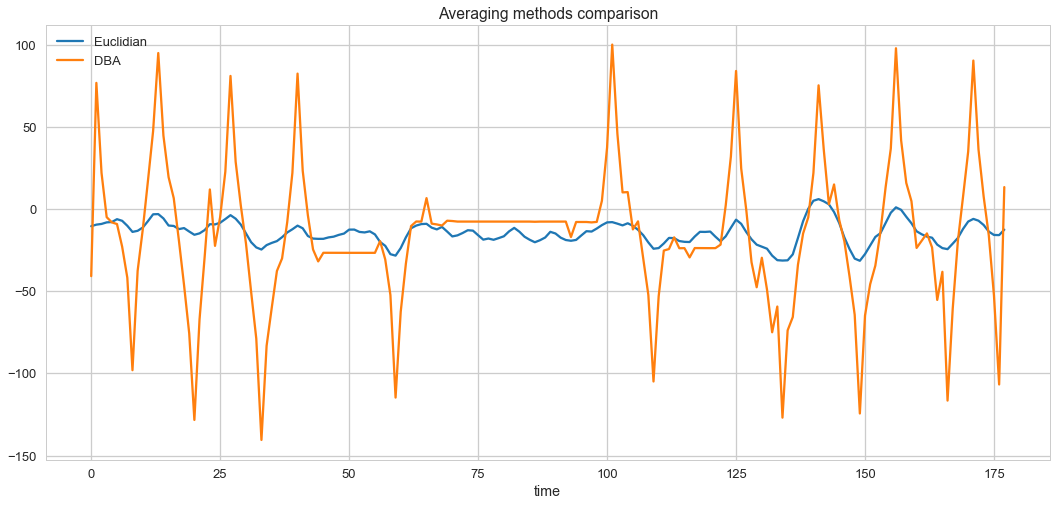

Category: 5


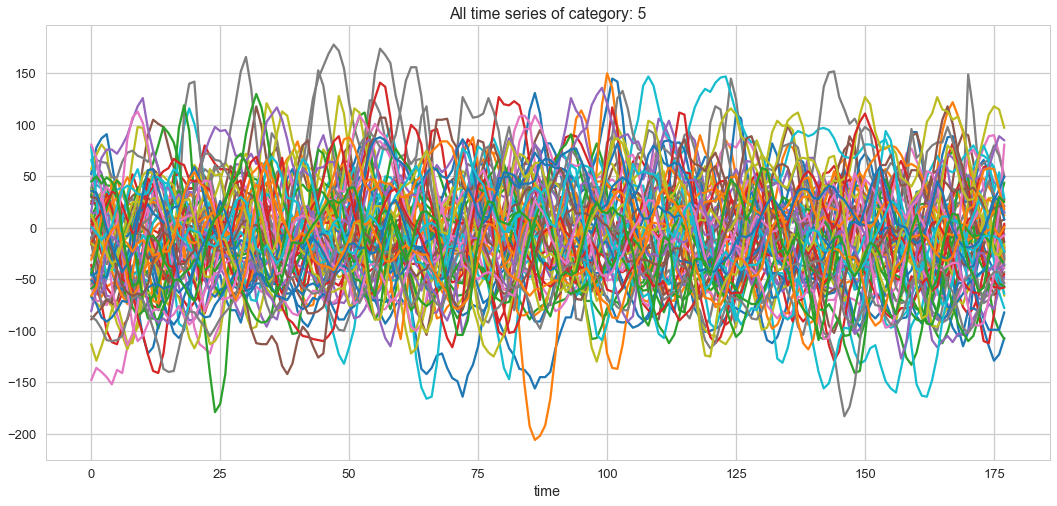

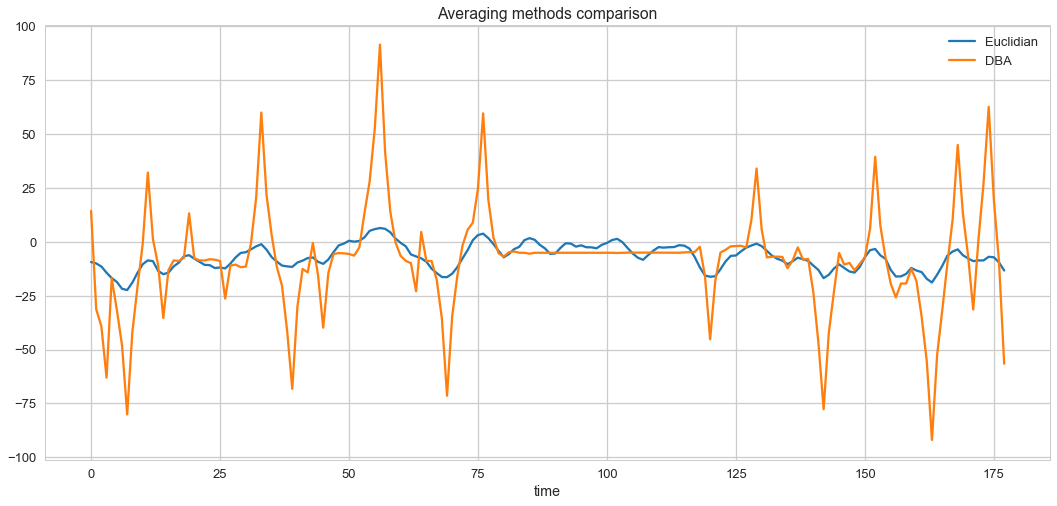

In [36]:
averages = {"euclidian": {}, "DTW": {}}

for v in sorted(set(y)):
    
    print("===========")
    print("Category:", v)
    print("===========")
    
    plt.title(f"All time series of category: {v}")
    plt.plot(X[y==v, :].T)
    plt.xlabel("time")
    plt.show()

    averages["euclidian"][v] = X[y==v, :].mean(axis=0)
    plt.plot(averages["euclidian"][v], label="Euclidian")

    center = softdtw_barycenter(X[y==v, :], max_iter=100)
    averages["DTW"][v] = center.ravel()
    plt.plot(center.ravel(), label=f"DBA")
    
    plt.title("Averaging methods comparison")
    plt.xlabel("time")
    plt.legend()
    plt.show()

#### Global Comparison

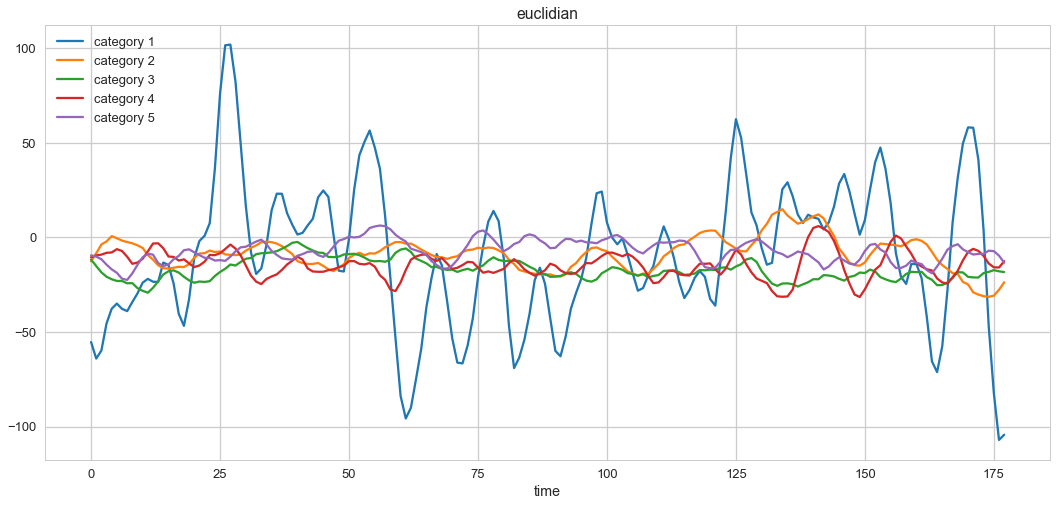

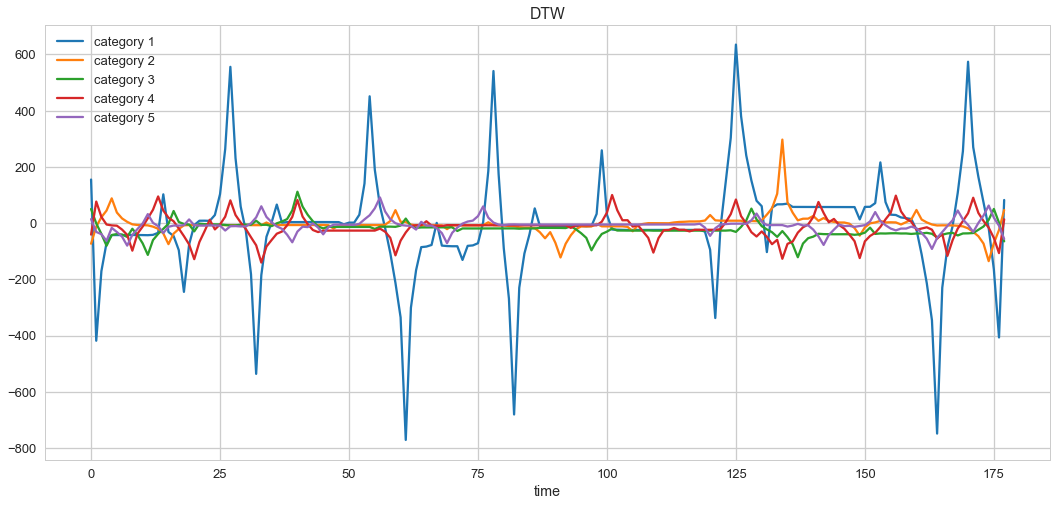

In [38]:
for method in averages.keys():
    for v in sorted(set(y)):
        plt.plot(averages[method][v], label=f"category {v}")
    plt.title(method)
    plt.xlabel("time")
    plt.legend()
    plt.savefig(f"{method}_averages.png")
    plt.show()

Alarming signals for epileptic seizures seem to be high frequent peaks in brain activity.